#RAG 실습 코드
https://www.youtube.com/watch?v=J2AsmUODBak&t=449s 에서 영상보며 공부한 것

In [1]:
!pip install -q langchain pypdf sentence-transformers chromadb openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 987.6/987.6 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.7/295.7 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 581.4/581.4 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.5/328.5 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 366.5/366.5 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.2/92.2 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 42.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━

## Multi-Query Retriever

In [3]:
!pip install -q langchain_community

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 6.3 MB/s eta 0:00:00


In [4]:
# Build a sample vectorDB
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain.embeddings import HuggingFaceEmbeddings

# Load blog post
loader = WebBaseLoader("https://n.news.naver.com/mnews/article/003/0012317114?sid=105")
data = loader.load()

# Split
text_splitter = RecursiveCharacterTextSplitter(chunk_size=300, chunk_overlap=0)
splits = text_splitter.split_documents(data)

# VectorDB
model_name = "jhgan/ko-sbert-nli"
encode_kwargs = {'normalize_embeddings': True}
ko_embedding = HuggingFaceEmbeddings(
    model_name=model_name,
    encode_kwargs=encode_kwargs
)

vectordb = Chroma.from_documents(documents=splits, embedding=ko_embedding)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 0.3.0. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFaceEmbeddings`.
  warn_deprecated(
/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/sett

In [6]:
from langchain.retrievers.multi_query import MultiQueryRetriever
from langchain.chat_models import ChatOpenAI
from google.colab import userdata
question = "삼성전자 갤럭시 S24는 어떨 예정이야?"
llm = ChatOpenAI(temperature=0, openai_api_key = userdata.get('op'))
retriever_from_llm = MultiQueryRetriever.from_llm(
    retriever=vectordb.as_retriever(), llm=llm
)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 0.3.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import ChatOpenAI`.
  warn_deprecated(


In [7]:
# Set logging for the queries
import logging

logging.basicConfig()
logging.getLogger("langchain.retrievers.multi_query").setLevel(logging.INFO)

In [8]:
unique_docs = retriever_from_llm.get_relevant_documents(query=question)
len(unique_docs)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(
INFO:langchain.retrievers.multi_query:Generated queries: ['1. 삼성 갤럭시 S24 출시 일정은 언제인가요?', '2. 삼성전자의 갤럭시 S24에 대한 최신 소식을 알고 싶어요.', '3. 갤럭시 S24의 기능과 스펙에 대해 알려주세요.']


5

In [9]:
unique_docs

[Document(metadata={'language': 'ko', 'source': 'https://n.news.naver.com/mnews/article/003/0012317114?sid=105', 'title': "언팩 D-4, 세계 최초 AI폰 '갤S24' 이렇게 나온다"}, page_content="[서울=뉴시스] 삼성전자가 17일 오전 10시(현지시간, 한국 시간 18일 오전 3시) 미국 캘리포니아주 산호세(새너제이)에서 '삼성 갤럭시 언팩 2024'를 열고 갤럭시 S24를 공개한다. 사진은 포르투갈에서 유출된 갤럭시 S24 시리즈 포스터 추정 이미지 (사진=theonecid 엑스 캡처)  *재판매 및 DB 금지[서울=뉴시스]윤정민 기자 = 인공지능(AI) 서비스가 대거 탑재될 삼성전자 플래그십 스마트폰 '갤럭시 S24'가 18일 베일을 벗는다. 갤럭시 S23이 전작 대비 카메라, 디자인 등 대폭 개선됐다면, 이번 신작은"),
 Document(metadata={'language': 'ko', 'source': 'https://n.news.naver.com/mnews/article/003/0012317114?sid=105', 'title': "언팩 D-4, 세계 최초 AI폰 '갤S24' 이렇게 나온다"}, page_content="[서울=뉴시스] 삼성전자가 17일 오전 10시(현지시간, 한국 시간 18일 오전 3시) 미국 캘리포니아주 산호세(새너제이)에서 열 '삼성 갤럭시 언팩 2024'의 주제는 '모바일 AI의 새로운 시대 개막'이다. 앞서 삼성전자가 AI를 스마트폰 차기작 특징으로 예고했던 만큼 어떤 AI 기능이 실릴지 관심이 쏠린다.삼성전자가 공식적으로 밝힌 AI 서비스는 실시간 통화 통역이다. 이미 SK텔레콤 '에이닷' 등 통화 통역을 지원하는 앱이 있다. 하지만 자체 AI가 탑재될 갤럭시 S24는 별도 앱을 설치하지 않아도 통역 통화를 이용할 수"),
 Document(metadata={'language': 'ko', 'source': 'h

## 기본 Parent-document Retriever

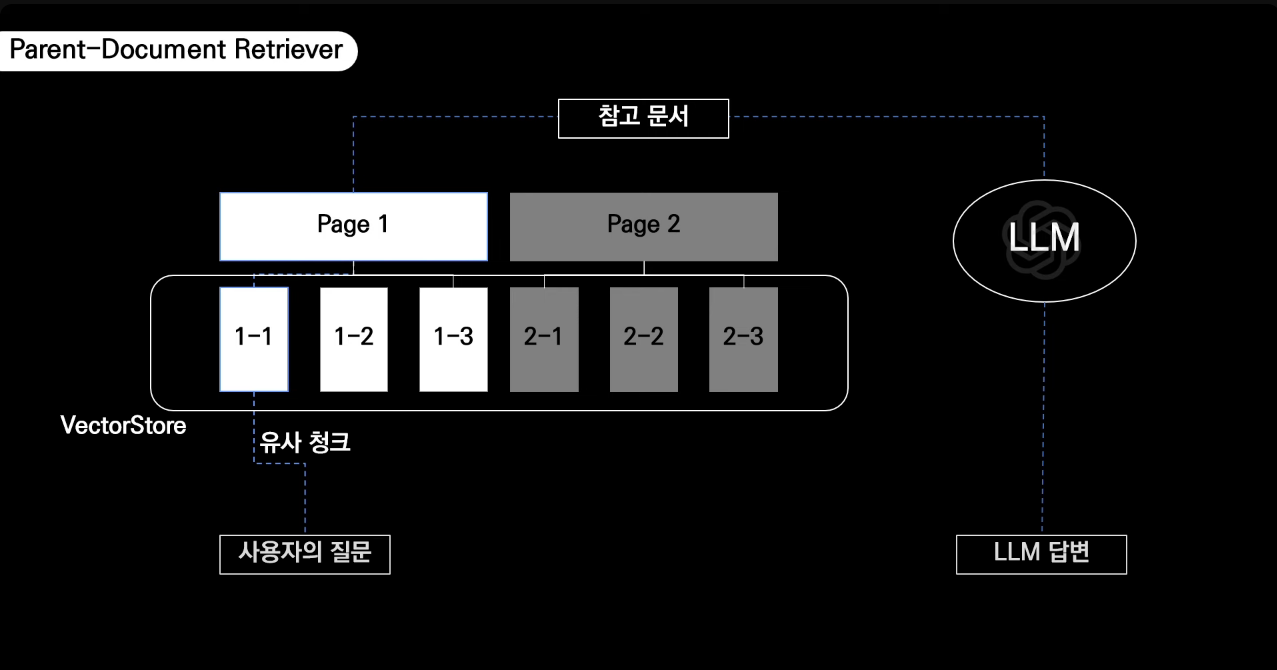

쿼리가 들어오면 유사 청크를 리트리버에서 찾는다. (찾는 방법은 안나옴 코사인 유사도 같은거 쓰겠지?)  
1-1이 가장 유사도가 높다면 1-1 청크를 넣는게 아니라 부모 문서인   
1페이지를 통째로 참고 문서로 사용한다.  
그러면 앞뒤 맥락을 포함해서 사용자의 의도를 파악하는데 훨씬 도움이 된다.

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
from langchain.retrievers import ParentDocumentRetriever

In [12]:
from langchain.storage import InMemoryStore #저장소에 dict 형태로 데이터를 저장하기 위한 함수 key는 부모 value는 아이들 형태로 저장함
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.document_loaders import PyPDFLoader
from langchain_community.vectorstores import Chroma
from langchain.embeddings import HuggingFaceEmbeddings


In [13]:
loaders = [
    PyPDFLoader("/content/drive/MyDrive/Colab Notebooks/트랜스포머/simple exam/고급 RAG 기법/[복지이슈 FOCUS 15ȣ] 경기도 극저신용대출심사모형 개발을 위한 국내 신용정보 활용가능성 탐색.pdf"),
    PyPDFLoader("/content/drive/MyDrive/Colab Notebooks/트랜스포머/simple exam/고급 RAG 기법/[이슈리포트 2022-2호] 혁신성장 정책금융 동향.pdf"),
]
docs = []
for loader in loaders:
    docs.extend(loader.load_and_split()) #pdf 페이지 별로 쪼개져서 docs에 들어감
'''
list.append(x)는 리스트 끝에 x 1개를 그대로 넣습니다.
list.extend(iterable)는 리스트 끝에 가장 바깥쪽 iterable의 모든 항목을 넣습니다.
'''

'\nlist.append(x)는 리스트 끝에 x 1개를 그대로 넣습니다.\nlist.extend(iterable)는 리스트 끝에 가장 바깥쪽 iterable의 모든 항목을 넣습니다.\n'

In [14]:
model_name = "jhgan/ko-sbert-nli" #한국어 모델
encode_kwargs = {'normalize_embeddings': True}
ko_embedding = HuggingFaceEmbeddings(
    model_name=model_name,
    encode_kwargs=encode_kwargs
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [15]:
# This text splitter is used to create the child documents
child_splitter = RecursiveCharacterTextSplitter(chunk_size=500) #청크 500짜리 자식 문서 만들기
# The vectorstore to use to index the child chunks
vectorstore = Chroma(
    collection_name="full_documents", embedding_function=ko_embedding
)
# The storage layer for the parent documents
store = InMemoryStore()
retriever = ParentDocumentRetriever(
    vectorstore=vectorstore,
    docstore=store,
    child_splitter=child_splitter,
)

In [16]:
retriever.add_documents(docs, ids=None)

In [17]:
sub_docs = vectorstore.similarity_search("인공지능 예산")#아이들 문서에서 가장 높은 유사도 문서 찾기

In [18]:
print("글 길이: {}\n\n".format(len(sub_docs[0].page_content)))
print(sub_docs[0].page_content)

글 길이: 423


(40.0) (40.2) (48.9) (32.8) (49.8)   
하드웨어30.9 43.1 60.2 89.2 118.3 176.5 41.7%
　 (39.5) (39.7) (48.2) (32.5) (49.2)   
     자료: Global Artificial Intelligence(AI) Market, BCC Research (2022)
￮인공지능 기술을 도입하는 산업이 늘어나고 있는 점, 인공지능 분야에 진출하는 스타트업의 증가에 
따라 산업의 기술경쟁력이 높아지는 점 등은 시장성장에  촉진요인으로 작용할 전망임
￮국내 인공지능 기술에 대한 완성도가 높지 않아 국내기술의 도입처가 제한적인 점, 인공지능이 
인간의 고용 영역을 침범할 수 있고 기술의 불안정성으로 인한 사고 발생의 우려가 존재하는 점 등은 
시장성장에 저해요인 으로 작용할 전망임


In [19]:
retrieved_docs = retriever.get_relevant_documents("인공지능 예산") #유사도가 가장 높은 청크의 부모 문서 가져옴

In [20]:
print("글 길이: {}\n\n".format(len(retrieved_docs[0].page_content)))
print(retrieved_docs[0].page_content)

글 길이: 1360


| 10 | CIS이슈리포트 2022-2 호 ▶인공지능 산업의 value chain 은 ‘AI 플랫폼 공급업체 → AI 어플리케이션 개발 → AI 응용솔루션  
개발 → 이용자 ’로 구성되며 , 동 산업은 ①성장기 산업, ②대체재로부터의 위협이 낮은 산업, ③기
술집약적 산업 등의 특징을 가짐
￮알고리즘 , 하드웨어 기술개발과 응용솔루션 서비스 상용화가 활발히 진행 중인 성장기 산업이며 , 
수요 기업의 요구사항에 따라 운영플랫폼을 선택할 수 있는 구매자의 교섭력이 높은 산업임
￮직접적인 대체 기술이 없어 대체재로부터 위협이 낮은 편이며 , 알고리즘의 동작원리를 이해하고 맞
춤형 서비스를 지원하기 위한 솔루션 개발 능력이 뒷받침 되어야 하는 기술집약적 산업임
▶시장조사전문기관 BCC research 에 따르면 세계 인공지능 시장규모는 2020년 398.4 억 달러에서  
연평균 41.0% 성장하여 2025 년에는 2,223.7 억 달러의 시장을 형성할 것으로 전망됨
￮세부 솔루션 분문별로는 2020 년 기준 소프트웨어 부문의 점유율이 전체시장의 78.3% 를 차지할 
정도로 압도적으로 높음
[세계 인공지능 시장규모 ]
                                                            (단위: 억 달러, 괄호는 YoY %)
구분 2020 2021 2022 2023 2024 2025CAGR
(2020-2025)
인공지능398.4 553.3 769.7 1,134.3 1,498.9 2,223.7 41.0%
　 (38.9) (39.1) (47.4) (32.1) (48.4)   
소프트웨어311.8 432.3 600.3 882.4 1,164.6 1,723.5 40.8%
　 (38.6) (38.8) (47.0) (32.0) (48.0)   
서비스55.7 78.0 109.3 162.6 216.0 323.7 42.2%
　 (40.0) (40.2) (48.9) (32.8) (49.8)   
하드웨어30.9 43.

## 본문의 Full_chunk가 너무 길때  
밑에 코드 블록 처럼 부모 리트리버는 자식 리트리버의 n배수가되도록 설정하여 길이를 조정한다.   
ParentDocumentRetriever함수에 부모 스플리터 인자를 추가해 해당 정보를 넣어준다.


In [21]:
# This text splitter is used to create the parent documents
parent_splitter = RecursiveCharacterTextSplitter(chunk_size=800)
# This text splitter is used to create the child documents
# It should create documents smaller than the parent
child_splitter = RecursiveCharacterTextSplitter(chunk_size=200)
# The vectorstore to use to index the child chunks
vectorstore = Chroma(
    collection_name="split_parents", embedding_function=ko_embedding
)
# The storage layer for the parent documents
store = InMemoryStore()

In [22]:
retriever = ParentDocumentRetriever(
    vectorstore=vectorstore,
    docstore=store,
    child_splitter=child_splitter,
    parent_splitter=parent_splitter,
)

In [23]:
retriever.add_documents(docs)

In [24]:
len(list(store.yield_keys()))

69

In [25]:
sub_docs = vectorstore.similarity_search("인공지능 예산")

In [26]:
print(sub_docs[0].page_content)

[세계 인공지능 시장규모 ]
                                                            (단위: 억 달러, 괄호는 YoY %)
구분 2020 2021 2022 2023 2024 2025CAGR
(2020-2025)
인공지능398.4 553.3 769.7 1,134.3 1,498.9 2,223.7 41.0%


In [27]:
len(sub_docs[0].page_content)

198

In [28]:
retrieved_docs = retriever.get_relevant_documents("인공지능 예산")

In [29]:
print(retrieved_docs[0].page_content)

| 10 | CIS이슈리포트 2022-2 호 ▶인공지능 산업의 value chain 은 ‘AI 플랫폼 공급업체 → AI 어플리케이션 개발 → AI 응용솔루션  
개발 → 이용자 ’로 구성되며 , 동 산업은 ①성장기 산업, ②대체재로부터의 위협이 낮은 산업, ③기
술집약적 산업 등의 특징을 가짐
￮알고리즘 , 하드웨어 기술개발과 응용솔루션 서비스 상용화가 활발히 진행 중인 성장기 산업이며 , 
수요 기업의 요구사항에 따라 운영플랫폼을 선택할 수 있는 구매자의 교섭력이 높은 산업임
￮직접적인 대체 기술이 없어 대체재로부터 위협이 낮은 편이며 , 알고리즘의 동작원리를 이해하고 맞
춤형 서비스를 지원하기 위한 솔루션 개발 능력이 뒷받침 되어야 하는 기술집약적 산업임
▶시장조사전문기관 BCC research 에 따르면 세계 인공지능 시장규모는 2020년 398.4 억 달러에서  
연평균 41.0% 성장하여 2025 년에는 2,223.7 억 달러의 시장을 형성할 것으로 전망됨
￮세부 솔루션 분문별로는 2020 년 기준 소프트웨어 부문의 점유율이 전체시장의 78.3% 를 차지할 
정도로 압도적으로 높음
[세계 인공지능 시장규모 ]
                                                            (단위: 억 달러, 괄호는 YoY %)
구분 2020 2021 2022 2023 2024 2025CAGR
(2020-2025)
인공지능398.4 553.3 769.7 1,134.3 1,498.9 2,223.7 41.0%
　 (38.9) (39.1) (47.4) (32.1) (48.4)


In [30]:
len(retrieved_docs[0].page_content)

797

## Self-querying

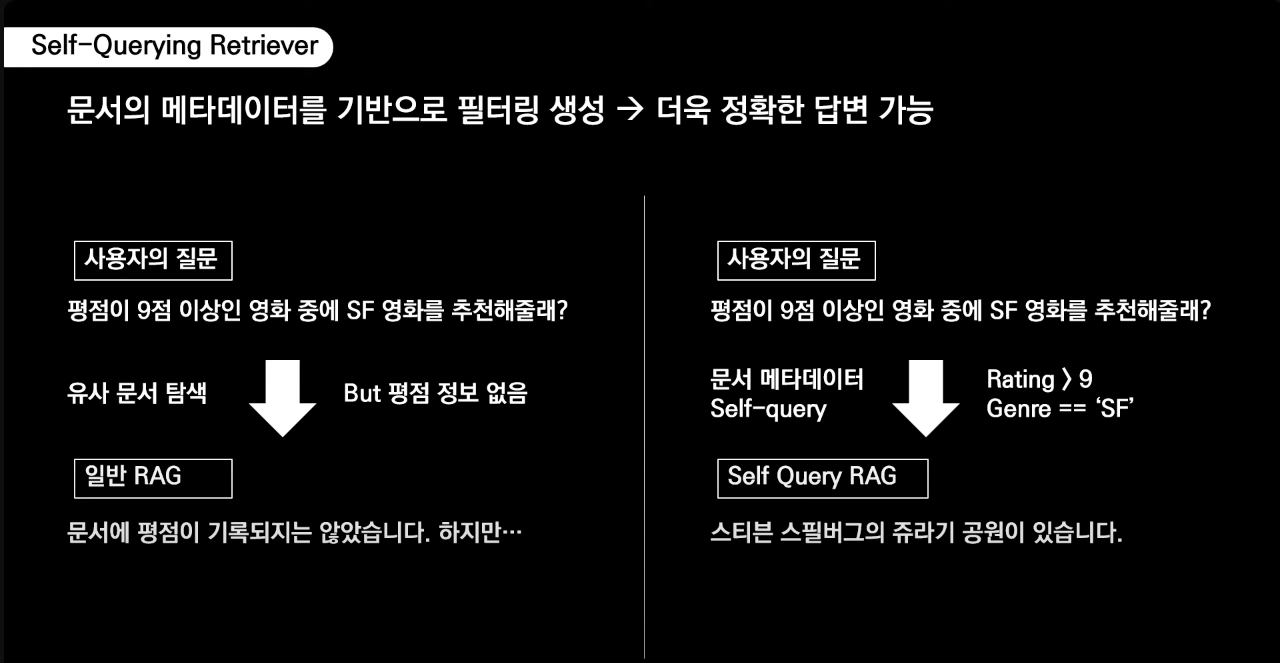

기존 RAG에서는 들어오는 쿼리를 바탕으로 유사 문서를 탐색했습니다.  
문제는 문서에 없는 메타 데이터의 정보가 들어오면 작동하지 않습니다.  
셀프 쿼리 시스템은 들어오는 쿼리를 기반으로 문서의 메타데이터를  
필터링하는 식을 만들고 그걸 바탕으로 답을 추론한다.  
따라서 해당 기법은 필터링이 필요한 작업에서나 쓸모있는 리트리버이다.  
보통 csv, excel, json 같은 데이터를 다룰때 유용하다.
***
아니 밑에 lark를 설치 했는데 왜 안되는지 모르겠음  
pip로 lark 설치하고 셀프쿼리 함수 불러왔는데 lark를 인식못함  
검색해보면 커널을 재시작하면 된다는데 코랩이라 재시작하면 어차피 초기화됨  
버전이 바뀌면서 디펜던시가 뭔가 바뀐거같음  
***
런타임 -> 세션 다시 시작을 계속 반복 하다보니 성공함 위에꺼 다시 실행하면 토큰 낭비니까  
필요한것만 밑에 추가해서 바로 사용하도록 수정함

In [1]:
pip install lark

In [5]:
from langchain.schema import Document
from langchain_community.vectorstores import Chroma

docs = [
    Document(
        page_content="A bunch of scientists bring back dinosaurs and mayhem breaks loose",
        metadata={"year": 1993, "rating": 7.7, "genre": "science fiction"},
    ),
    Document(
        page_content="Leo DiCaprio gets lost in a dream within a dream within a dream within a ...",
        metadata={"year": 2010, "director": "Christopher Nolan", "rating": 8.2},
    ),
    Document(
        page_content="A psychologist / detective gets lost in a series of dreams within dreams within dreams and Inception reused the idea",
        metadata={"year": 2006, "director": "Satoshi Kon", "rating": 8.6},
    ),
    Document(
        page_content="A bunch of normal-sized women are supremely wholesome and some men pine after them",
        metadata={"year": 2019, "director": "Greta Gerwig", "rating": 8.3},
    ),
    Document(
        page_content="Toys come alive and have a blast doing so",
        metadata={"year": 1995, "genre": "animated"},
    ),
    Document(
        page_content="Three men walk into the Zone, three men walk out of the Zone",
        metadata={
            "year": 1979,
            "director": "Andrei Tarkovsky",
            "genre": "thriller",
            "rating": 9.9,
        },
    ),
]
# VectorDB
model_name = "jhgan/ko-sbert-nli"
encode_kwargs = {'normalize_embeddings': True}
ko_embedding = HuggingFaceEmbeddings(
    model_name=model_name,
    encode_kwargs=encode_kwargs
)
vectorstore = Chroma.from_documents(docs, ko_embedding)

In [7]:
from langchain.chains.query_constructor.base import AttributeInfo
from langchain.retrievers.self_query.base import SelfQueryRetriever
from langchain.chat_models import ChatOpenAI
from google.colab import userdata
metadata_field_info = [  #이 데이터 기반으로 필터링을 적용함 각 객체마다 뭘 의미하는지 설명이 있음
    AttributeInfo(
        name="genre",
        description="The genre of the movie. One of ['science fiction', 'comedy', 'drama', 'thriller', 'romance', 'action', 'animated']",
        type="string",
    ),
    AttributeInfo(
        name="year",
        description="The year the movie was released",
        type="integer",
    ),
    AttributeInfo(
        name="director",
        description="The name of the movie director",
        type="string",
    ),
    AttributeInfo(
        name="rating", description="A 1-10 rating for the movie", type="float"
    ),
]
document_content_description = "Brief summary of a movie" #content의 대한 설명
llm = ChatOpenAI(temperature=0, openai_api_key = userdata.get('op'))


/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 0.3.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import ChatOpenAI`.
  warn_deprecated(


In [8]:
retriever = SelfQueryRetriever.from_llm(
    llm,
    vectorstore,
    document_content_description,
    metadata_field_info,
    verbose = True
)

In [9]:
retriever.get_relevant_documents("what are some movies rated higher than 8.5")

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


[Document(metadata={'director': 'Andrei Tarkovsky', 'genre': 'thriller', 'rating': 9.9, 'year': 1979}, page_content='Three men walk into the Zone, three men walk out of the Zone'),
 Document(metadata={'director': 'Satoshi Kon', 'rating': 8.6, 'year': 2006}, page_content='A psychologist / detective gets lost in a series of dreams within dreams within dreams and Inception reused the idea')]

## Time-weighted vector store Retriever

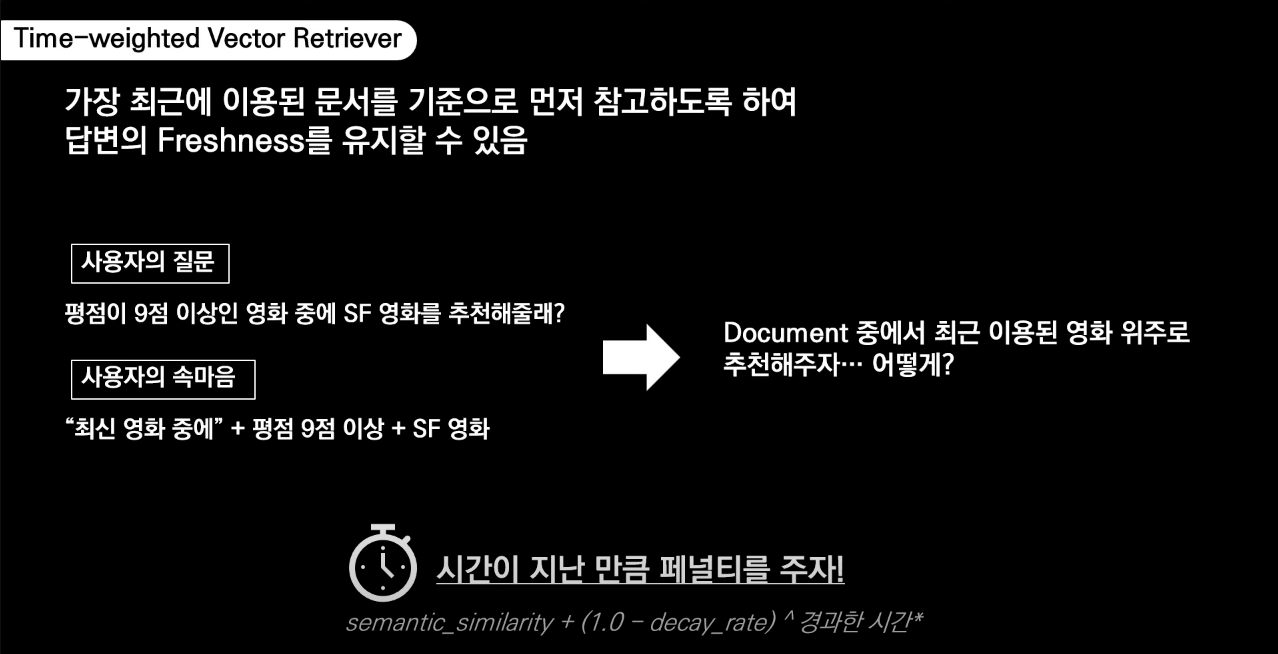

Scoring 방법 = *semantic_similarity + (1.0 - decay_rate) ^ hours_passed*

In [10]:
!pip install -q faiss-gpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 2.0 MB/s eta 0:00:00


In [12]:
from datetime import datetime, timedelta #시간을 다루기때문에 사

import faiss #벡터 스토어
from langchain.docstore import InMemoryDocstore
from langchain.retrievers import TimeWeightedVectorStoreRetriever
from langchain.schema import Document
from langchain_community.vectorstores import FAISS


In [13]:
# Initialize the vectorstore as empty
embedding_size = 768 #사용하는 임베딩 모델의 사이즈에 맞게 값을 사용
index = faiss.IndexFlatL2(embedding_size)
vectorstore = FAISS(ko_embedding, index, InMemoryDocstore({}), {})
retriever = TimeWeightedVectorStoreRetriever(
    vectorstore=vectorstore, decay_rate=0.99, k=1
)

In [14]:
yesterday = datetime.now() - timedelta(days=1)
retriever.add_documents(
    [Document(page_content="영어는 훌륭합니다.", metadata={"last_accessed_at": yesterday})] #어제 데이터를 추가했다고 가정
)
retriever.add_documents([Document(page_content="한국어는 훌륭합니다")]) #지금 추가한 데이터

['79d12c7d-5de8-4e76-8f7d-5c636001dd7e']

In [15]:
# "Hello World" is returned first because it is most salient, and the decay rate is close to 0., meaning it's still recent enough
retriever.get_relevant_documents("영어가 좋아요")
#decay_rate로 시간 패널티를 크게 하니까 결과가 한국어로 나옴
#영어가 더 높은 유사일 텐데 시간 패널티때문에 최신거를 더 높게 보고있음

[Document(metadata={'last_accessed_at': datetime.datetime(2024, 7, 16, 6, 54, 17, 625560), 'created_at': datetime.datetime(2024, 7, 16, 6, 54, 15, 664113), 'buffer_idx': 1}, page_content='한국어는 훌륭합니다')]

## Ensemble Retriever

In [ ]:
!pip install -q langchain pypdf sentence-transformers chromadb langchain-openai faiss-gpu --upgrade --quiet  rank_bm25 > /dev/null

In [ ]:
from langchain.retrievers import BM25Retriever, EnsembleRetriever
from langchain_community.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings

In [ ]:
model_name = "jhgan/ko-sbert-nli"
encode_kwargs = {'normalize_embeddings': True}
ko_embedding = HuggingFaceEmbeddings(
    model_name=model_name,
    encode_kwargs=encode_kwargs
)

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.document_loaders import PyPDFLoader

loaders = [
    PyPDFLoader("/content/drive/MyDrive/강의 자료/[복지이슈 FOCUS 15ȣ] 경기도 극저신용대출심사모형 개발을 위한 국내 신용정보 활용가능성 탐색.pdf"),
    PyPDFLoader("/content/drive/MyDrive/강의 자료/[이슈리포트 2022-2호] 혁신성장 정책금융 동향.pdf"),
]
docs = []
for loader in loaders:
    docs.extend(loader.load_and_split())

text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
texts = text_splitter.split_documents(docs)

In [ ]:
# initialize the bm25 retriever and faiss retriever
bm25_retriever = BM25Retriever.from_documents(texts)
bm25_retriever.k = 2



embedding = ko_embedding
faiss_vectorstore = FAISS.from_documents(texts, ko_embedding)
faiss_retriever = faiss_vectorstore.as_retriever(search_kwargs={"k": 2})

# initialize the ensemble retriever
ensemble_retriever = EnsembleRetriever(
    retrievers=[bm25_retriever, faiss_retriever], weights=[0.5, 0.5]
)

In [ ]:
docs = ensemble_retriever.invoke("혁신정책금융과 극저신용대출모형의 차이")
for i in docs:

  print(i.metadata)
  print(":")
  print(i.page_content)
  print("-"*100)

In [ ]:
faiss_vectorstore = FAISS.from_documents(texts, ko_embedding)
faiss_retriever = faiss_vectorstore.as_retriever(search_kwargs={"k": 4})

docs = faiss_retriever.invoke("혁신정책금융과 극저신용대출모형의 차이")
for i in docs:

  print(i.metadata)
  print(":")
  print(i.page_content)
  print("-"*100)

In [ ]:
import os
os.environ["OPENAI_API_KEY"] = 'YOUR_API_KEY'

from langchain.chains import RetrievalQA
from langchain_openai import ChatOpenAI

openai = ChatOpenAI(model_name="gpt-3.5-turbo", temperature = 0)

qa = RetrievalQA.from_chain_type(llm = openai,
                                 chain_type = "stuff",
                                 retriever = ensemble_retriever,
                                 return_source_documents = True)

query = "극저신용자 대출의 신용등급"
result = qa(query)
print(result['result'])

In [ ]:
for i in result['source_documents']:
  print(i.metadata)
  print("-"*100)
  print(i.page_content)
  print("-"*100)

In [ ]:
faiss_vectorstore = FAISS.from_documents(docs, ko_embedding)
faiss_retriever = faiss_vectorstore.as_retriever(search_kwargs={"k": 4})

qa = RetrievalQA.from_chain_type(llm = openai,
                                 chain_type = "stuff",
                                 retriever = faiss_retriever,
                                 return_source_documents = True)

query = "극저신용자 대출의 신용등급"
result = qa(query)
print(result['result'])

In [ ]:
for i in result['source_documents']:
  print(i.metadata)
  print("-"*100)
  print(i.page_content)
  print("-"*100)

## Long Context Reorder

In [ ]:
from langchain.chains import LLMChain, StuffDocumentsChain
from langchain.prompts import PromptTemplate
from langchain_community.document_transformers import (
    LongContextReorder,
)
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAI

texts = [
    "바스켓볼은 훌륭한 스포츠입니다.",
    "플라이 미 투 더 문은 제가 가장 좋아하는 노래 중 하나입니다.",
    "셀틱스는 제가 가장 좋아하는 팀입니다.",
    "보스턴 셀틱스에 관한 문서입니다.", "보스턴 셀틱스는 제가 가장 좋아하는 팀입니다.",
    "저는 영화 보러 가는 것을 좋아해요",
    "보스턴 셀틱스가 20점차로 이겼어요",
    "이것은 그냥 임의의 텍스트입니다.",
    "엘든 링은 지난 15 년 동안 최고의 게임 중 하나입니다.",
    "L. 코넷은 최고의 셀틱스 선수 중 한 명입니다.",
    "래리 버드는 상징적 인 NBA 선수였습니다.",
]

# Create a retriever
retriever = Chroma.from_texts(texts, embedding=ko_embedding).as_retriever(
    search_kwargs={"k": 10}
)
query = "셀틱스에 대해 어떤 이야기를 들려주시겠어요?"

# Get relevant documents ordered by relevance score
docs = retriever.get_relevant_documents(query)
docs

In [ ]:
reordering = LongContextReorder()
reordered_docs = reordering.transform_documents(docs)

# Confirm that the 4 relevant documents are at beginning and end.
reordered_docs

In [ ]:
from langchain.chains import LLMChain, StuffDocumentsChain
from langchain.prompts import PromptTemplate
import os
os.environ["OPENAI_API_KEY"] = 'YOUR_API_KEY'

from langchain.chains import RetrievalQA
from langchain_openai import ChatOpenAI

document_prompt = PromptTemplate(
    input_variables=["page_content"], template="{page_content}"
)

template = """Given this text extracts:
-----
{context}
-----
Please answer the following question:
{query}"""
prompt = PromptTemplate(
    template=template, input_variables=["context", "query"]
)
openai = ChatOpenAI(model_name="gpt-3.5-turbo", temperature = 0)

llm_chain = LLMChain(llm=openai, prompt=prompt)
chain = StuffDocumentsChain(
    llm_chain=llm_chain,
    document_prompt=document_prompt,
    document_variable_name="context"
)


In [ ]:
reordered_result = chain.run(input_documents=reordered_docs, query=query)
result = chain.run(input_documents=docs, query=query)

print(reordered_result)
print("-"*100)
print(result)